### Zindi Mobile Banking - Capstone Project

### Loading Libraries

In [1]:
# Import global libraries
import pandas as pd
import scipy as scipy
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns

# Import algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import *
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Import scoring function
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# Split function
from sklearn.model_selection import train_test_split

# Algorithm optimizer and pipeline optimizer
from sklearn.model_selection import GridSearchCV
from tpot import TPOTClassifier
from sklearn.metrics import log_loss,accuracy_score

# Additional functions
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.multiclass import OneVsOneClassifier

C:\Users\Flal2\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\Flal2\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Data Exploration
Part of the data exploration has been done in Excel, Power BI and on the ArcGis platform. The following code is the exploration done in python.

### Loading Files - Finscope Survey 2017

In [2]:
# Loading files - Finscope Survey 2017
train = pd.read_csv('training.csv',decimal=".")
# Load the training file again for further need
train1 = pd.read_csv('training.csv',decimal=".")
# the test set is the test for the predictions on the plateform. 
# But for training the model we will need to divide the training set in two : Train and Test
# We will thus rename this data set "to_predict" to clarify
to_predict = pd.read_csv('test.csv',decimal=".")
# Load the prediction file again for further need
to_predict2 = pd.read_csv('test.csv',decimal=".")

#### Basic information and statistics about training and test set

In [3]:
train.head()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,Q17,Q18,Q19,Latitude,Longitude,mobile_money,savings,borrowing,insurance,mobile_money_classification
0,5086,98,2,3,1,1,2,2,0,0,...,-1,4,4,-4.460442,29.811396,0,0,0,0,0
1,1258,40,1,1,3,5,1,1,1,0,...,4,1,4,-6.176438,39.244871,1,1,1,0,3
2,331,18,2,4,6,3,2,1,0,0,...,-1,1,1,-6.825702,37.652798,1,0,0,0,2
3,6729,50,1,1,3,1,1,1,0,0,...,-1,1,4,-3.372049,35.808307,1,0,1,0,3
4,8671,34,1,1,1,1,2,1,0,1,...,-1,1,4,-7.179645,31.039095,1,1,0,1,3


In [4]:
train.shape

(7094, 37)

In [5]:
train.dtypes

ID                               int64
Q1                               int64
Q2                               int64
Q3                               int64
Q4                               int64
Q5                               int64
Q6                               int64
Q7                               int64
Q8_1                             int64
Q8_2                             int64
Q8_3                             int64
Q8_4                             int64
Q8_5                             int64
Q8_6                             int64
Q8_7                             int64
Q8_8                             int64
Q8_9                             int64
Q8_10                            int64
Q8_11                            int64
Q9                               int64
Q10                              int64
Q11                              int64
Q12                              int64
Q13                              int64
Q14                              int64
Q15                      

In [6]:
to_predict.shape

(2365, 32)

### Loading files - FSDT Financial Access Mapping

In [7]:
# Loading files - FSDT Financial Access Mapping - Banks
banks = pd.read_csv('banks_for_upload_win.csv',decimal=".")

In [8]:
banks.head()

,region,district,ward,latitude,longitude,bank_type,bank_name,weekend_trading,yr_started,yr_started_reformatted
0,Dar es Salaam,Temeke,Mbagala,-6.92247,39.27113,Commercial Bank,Accessbank (Tanzania) Limited,Yes,16/05/11,2011-5-01
1,Shinyanga,Kahama,Kahama Mjini,-3.82858,32.60006,Commercial Bank,Accessbank (Tanzania) Limited,No,12/07/13,2013-7-01
2,Dar es Salaam,Temeke,Miburani,-6.86209,39.26233,Commercial Bank,Accessbank (Tanzania) Limited,Yes,05/03/98,1998-3-01
3,Dar es Salaam,Ilala,Kariakoo,-6.82157,39.28025,Commercial Bank,Accessbank (Tanzania) Limited,Yes,10/06/09,2009-6-01
4,Dar es Salaam,Ilala,Kariakoo,-6.81944,39.27418,Commercial Bank,Accessbank (Tanzania) Limited,Yes,18/12/13,2013-12-01


#### How many additional financial services ?

In [9]:
# Create feature for hierarchical classification : Has access to at least one of the other financial services ?
train1['Additional_Fin_Service'] = train1['savings']+train1['borrowing']+train1['insurance']
# How many other financial service
train1['Additional_Fin_Service'].value_counts()

1    2740
0    2190
2    1814
3     350
Name: Additional_Fin_Service, dtype: int64

### Loading files - ArcGis Files - Distances & Data Enrichment of the Train DataSet

In [10]:
# Extract from ArcGis on the distance of each point with the closest bank
distances_to_bank = pd.read_csv('Train_to_banks_Conso.csv',decimal=".")
# remove duplicates in the distances_to_bank file keeping only the closest banks
distances_to_bank_reduced = distances_to_bank.sort_values('Total_Kilometers')
distances_to_bank_reduced = distances_to_bank_reduced.drop_duplicates(subset='From_ID_Orig', keep='first')
# merging with the training dataset
distances_final = distances_to_bank_reduced[['From_ID_Orig','Total_Kilometers']]
distances_final.columns = ['ID','KM_to_bank']
train = pd.merge(train, distances_final, on=['ID'],how='left')
# remplacing the NaN values by 100km (the filter in Arcgis was 100km and above)
train = train.fillna(100)
# remplacing all values above 100km by 100km
train['KM_to_bank'] = train['KM_to_bank'].apply(lambda x : 100 if x>100 else x)

In [11]:
# Extract from ArcGis on the distance of each point with the closest mobile_money_vendor
distances_to_mobile = pd.read_csv('Train_mobile_500_Conso.csv',decimal=".")

In [12]:
# remove duplicates in the distances_to_mobile file keeping only the closest mobile money vendors
distances_to_mobile_reduced = distances_to_mobile.sort_values('Total_Kilometers')
distances_to_mobile_reduced = distances_to_mobile_reduced.drop_duplicates(subset='From_ID_Orig', keep='first')
# merging with the training dataset
distances_to_mobile_final = distances_to_mobile_reduced[['From_ID_Orig','Total_Kilometers']]
distances_to_mobile_final.columns = ['ID','KM_to_mobile']
train = pd.merge(train, distances_to_mobile_final, on=['ID'],how='left')
# remplacing the NaN values by 400km (the filter in Arcgis was 400km and above for the test set)
train = train.fillna(400)
# remplacing all values above 400km by 400km
train['KM_to_mobile'] = train['KM_to_mobile'].apply(lambda x : 400 if x>400 else x)

### Loading files - ArcGis Files - Distances & Data Enrichment of the Test DataSet

In [13]:
# Extract from ArcGis on the distance of each point with the closest bank
distances_to_bank_to_predict = pd.read_csv('Test_to_banks.csv',decimal=".")
# remove duplicates in the distances_to_bank file keeping only the closest banks
distances_to_bank_reduced_to_predict = distances_to_bank_to_predict.sort_values('Total_Kilometers')
distances_to_bank_reduced_to_predict = distances_to_bank_reduced_to_predict.drop_duplicates(subset='From_ID_Orig', keep='first')
# merging with the training dataset
distances_final_to_predict = distances_to_bank_reduced_to_predict[['From_ID_Orig','Total_Kilometers']]
distances_final_to_predict.columns = ['ID','KM_to_bank']
to_predict = pd.merge(to_predict, distances_final_to_predict, on=['ID'],how='left')
# remplacing the NaN values by 100km (the filter in Arcgis was 100km and above)
to_predict = to_predict.fillna(100)
# remplacing all values above 100km by 100km
to_predict['KM_to_bank'] = to_predict['KM_to_bank'].apply(lambda x : 100 if x>100 else x)

In [14]:
# Extract from ArcGis on the distance of each point with the closest mobile_money_vendor
distances_to_mobile_to_predict = pd.read_csv('Test_mobile_400.csv',decimal=".")

In [15]:
# remove duplicates in the distances_to_mobile file keeping only the closest mobile money vendors
distances_to_mobile_reduced_to_predict = distances_to_mobile_to_predict.sort_values('Total_Kilometers')
distances_to_mobile_reduced_to_predict = distances_to_mobile_reduced_to_predict.drop_duplicates(subset='From_ID_Orig', keep='first')
# merging with the training dataset
distances_to_mobile_final_to_predict = distances_to_mobile_reduced_to_predict[['From_ID_Orig','Total_Kilometers']]
distances_to_mobile_final_to_predict.columns = ['ID','KM_to_mobile']
to_predict = pd.merge(to_predict, distances_to_mobile_final_to_predict, on=['ID'],how='left')
# remplacing the NaN values by 400km (the filter in Arcgis was 400km and above for the test set)
to_predict = to_predict.fillna(400)
# remplacing all values above 400km by 400km
to_predict['KM_to_mobile'] = to_predict['KM_to_mobile'].apply(lambda x : 400 if x>400 else x)

### Loading files - ArcGis Files - Regional Informations & Data Enrichment of the Training DataSet

In [16]:
# loading the infos by regions
info_regions = pd.read_csv('Info_Regions.csv',delimiter=';')
info_regions = info_regions.rename(columns={'Region': 'Region_Nam'})

In [17]:
info_regions.head()

,Region_Nam,2016 Purchasing Power : Per Capita,2016 Average Household Size,2016 Population Density (per sq. km),% Bank access within 5km
0,Arusha,1323743,4.5,48,65
1,Dar es Salaam,2073935,4.0,3378,100
2,Dodoma,907520,4.6,55,38
3,Geita,901933,6.1,95,37
4,Iringa,1167978,4.3,29,22


In [18]:
info_regions.columns

Index(['Region_Nam', '2016 Purchasing Power : Per Capita ',
       '2016 Average Household Size', '2016 Population Density (per sq. km)',
       '% Bank access within 5km'],
      dtype='object')

In [19]:
to_predict.columns

Index(['ID', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8_1', 'Q8_2', 'Q8_3',
       'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q9',
       'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19',
       'Latitude', 'Longitude', 'KM_to_bank', 'KM_to_mobile'],
      dtype='object')

In [20]:
# Load the regional file to enrich the Training Set(extracted from Arcgis)
Train_Regions = pd.read_csv('Train_Regions.csv',decimal=".")
Train_Regions_reduced = Train_Regions[['ID','Region_Nam']]
Train_Regions_add = pd.merge(Train_Regions_reduced, info_regions, on=['Region_Nam'],how='left')
train = pd.merge(train, Train_Regions_add, on=['ID'],how='left')
#train['Region_Nam'] = train['Region_Nam'].fillna('Unknown')
train = train.fillna(train.mean())

### Loading files - ArcGis Files - Regional Informations & Data Enrichment of the Testing DataSet

In [21]:
# Load the regional file to enrich the Test Set (extracted from Arcgis)
Test_Regions = pd.read_csv('Test_Regions.csv',decimal=".")
Test_Regions_reduced = Test_Regions[['ID','Region_Nam']]
Test_Regions_add = pd.merge(Test_Regions_reduced, info_regions, on=['Region_Nam'],how='left')
to_predict = pd.merge(to_predict, Test_Regions_add, on=['ID'],how='left')
#train['Region_Nam'] = train['Region_Nam'].fillna('Unknown')
to_predict = to_predict.fillna(train.mean())

### Distribution of the targets - Training Set

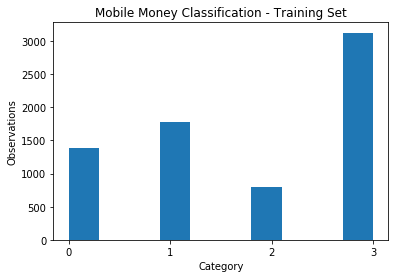

In [22]:
# Distribution of the targets in the training set
plt.hist(train['mobile_money_classification'])
plt.xlabel('Category')
plt.ylabel('Observations')
plt.title('Mobile Money Classification - Training Set')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.bins()
plt.xticks([0,1,2,3])
plt.show()

In [23]:
# % of each target in the training set
train['mobile_money_classification'].value_counts()/train['mobile_money_classification'].count()

3    0.440654
1    0.250634
0    0.195376
2    0.113335
Name: mobile_money_classification, dtype: float64

### Visualization function creation

In [24]:
# creation of a function to visualize the distribution of the values of a column in a dataframe
def visualize_hist(dataframe,column_name):
    print(dataframe[column_name].hist())
    print('Min : {}'.format(dataframe[column_name].min()))
    print('Max : {}'.format(dataframe[column_name].max()))
    print('Mode : {}'.format(dataframe[column_name].mode()[0]))
    print('Mean : {}'.format(dataframe[column_name].mean()))

AxesSubplot(0.125,0.125;0.775x0.755)
Min : 757299
Max : 2073935
Mode : 757299
Mean : 1068502.8


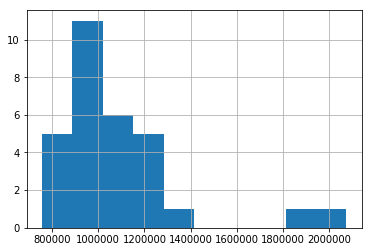

In [25]:
visualize_hist(info_regions,'2016 Purchasing Power : Per Capita ')

In [26]:
# creation of a function to visualize the distribution and the quantiles of the values of a column in a dataframe
def visualize_quantiles(dataframe,column_name):
    quantile_list = [0, .25, .5, .75, 1.]
    quantiles = dataframe[column_name].quantile(quantile_list)
    quantiles
    fig, ax = plt.subplots()
    dataframe[column_name].hist(bins=30, color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)
    ax.set_title(column_name, 
                 fontsize=12)
    #ax.set_xlabel('KM', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

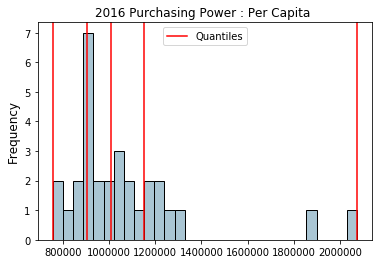

In [27]:
visualize_quantiles(info_regions,'2016 Purchasing Power : Per Capita ')

In [28]:
# creation of a function to visualize relationship between features and targets
def plot_relationship(dataframe,column1,column2):
    print(sns.scatterplot(x=column1,y=column2,hue='mobile_money',alpha=0.1,data=dataframe))
    plt.show()
    print(sns.scatterplot(x=column1,y=column2,hue='borrowing',alpha=0.1,data=dataframe))
    plt.show()
    print(sns.scatterplot(x=column1,y=column2,hue='savings',alpha=0.1,data=dataframe))
    plt.show()
    print(sns.scatterplot(x=column1,y=column2,hue='insurance',alpha=0.1,data=dataframe))
    plt.show()

### Data Structure Analysis

In [29]:
# Structure of training and testing Set
print('Training Set contains : {} items'.format(train.shape[0]))
print('Prediction Set contains : {} items'.format(to_predict.shape[0]))
print('Proportion Training Set on Total : {} %'.format(round(train.shape[0]*100/(train.shape[0]+to_predict.shape[0]),1)))

Training Set contains : 7094 items
Prediction Set contains : 2365 items
Proportion Training Set on Total : 75.0 %


In [30]:
# The training set has 32 columns for classification + 5 columns of "Target"
train.head()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,borrowing,insurance,mobile_money_classification,KM_to_bank,KM_to_mobile,Region_Nam,2016 Purchasing Power : Per Capita,2016 Average Household Size,2016 Population Density (per sq. km),% Bank access within 5km
0,5086,98,2,3,1,1,2,2,0,0,...,0,0,0,34.085336,1.110439,Kigoma,817645.0,5.7,51.0,30.0
1,1258,40,1,1,3,5,1,1,1,0,...,1,0,3,2.213349,0.533324,Mjini Magharibi,1861535.0,5.3,3673.0,96.0
2,331,18,2,4,6,3,2,1,0,0,...,0,0,2,1.129646,0.359524,Morogoro,1066101.0,4.4,36.0,37.0
3,6729,50,1,1,3,1,1,1,0,0,...,1,0,3,14.759292,0.513033,Arusha,1323743.0,4.5,48.0,65.0
4,8671,34,1,1,1,1,2,1,0,1,...,0,1,3,35.708657,3.702071,Rukwa,860009.0,5.1,41.0,16.0


### Correlation between Features

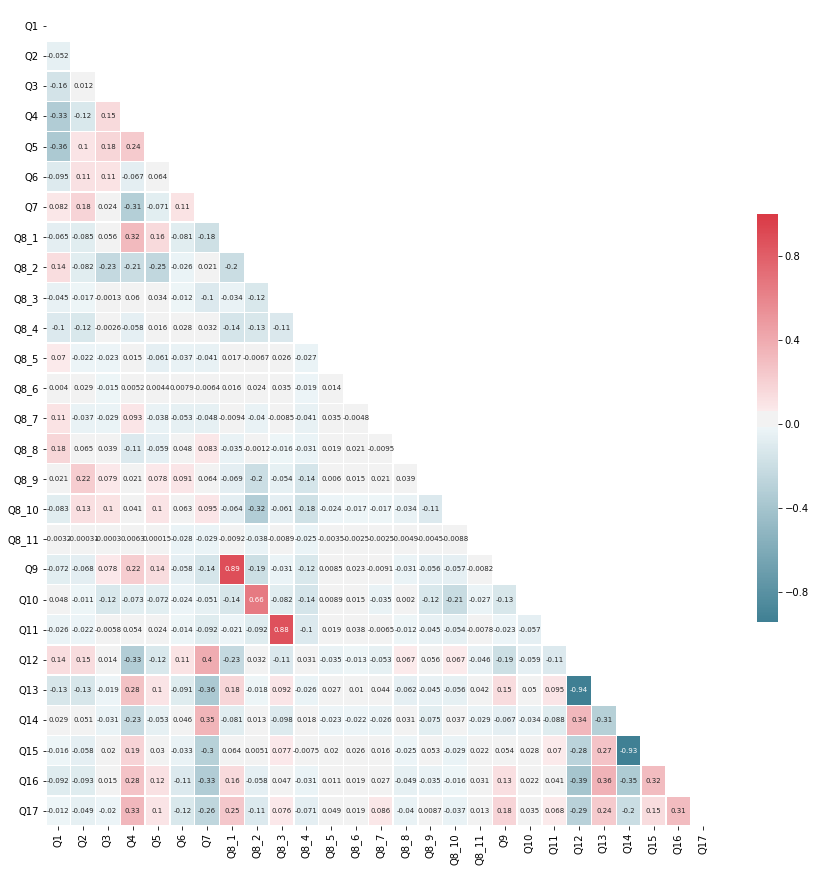

In [31]:
# create a heatmap of the correlations between features
f, ax = plt.subplots(figsize=(15, 15))
corr = train1.iloc[:,1:28].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train1.iloc[:,1:28].corr(), cmap=cmap,annot=True, mask=mask,linewidths=.5, ax=ax,cbar_kws={"shrink": .5},annot_kws={"size": 7})

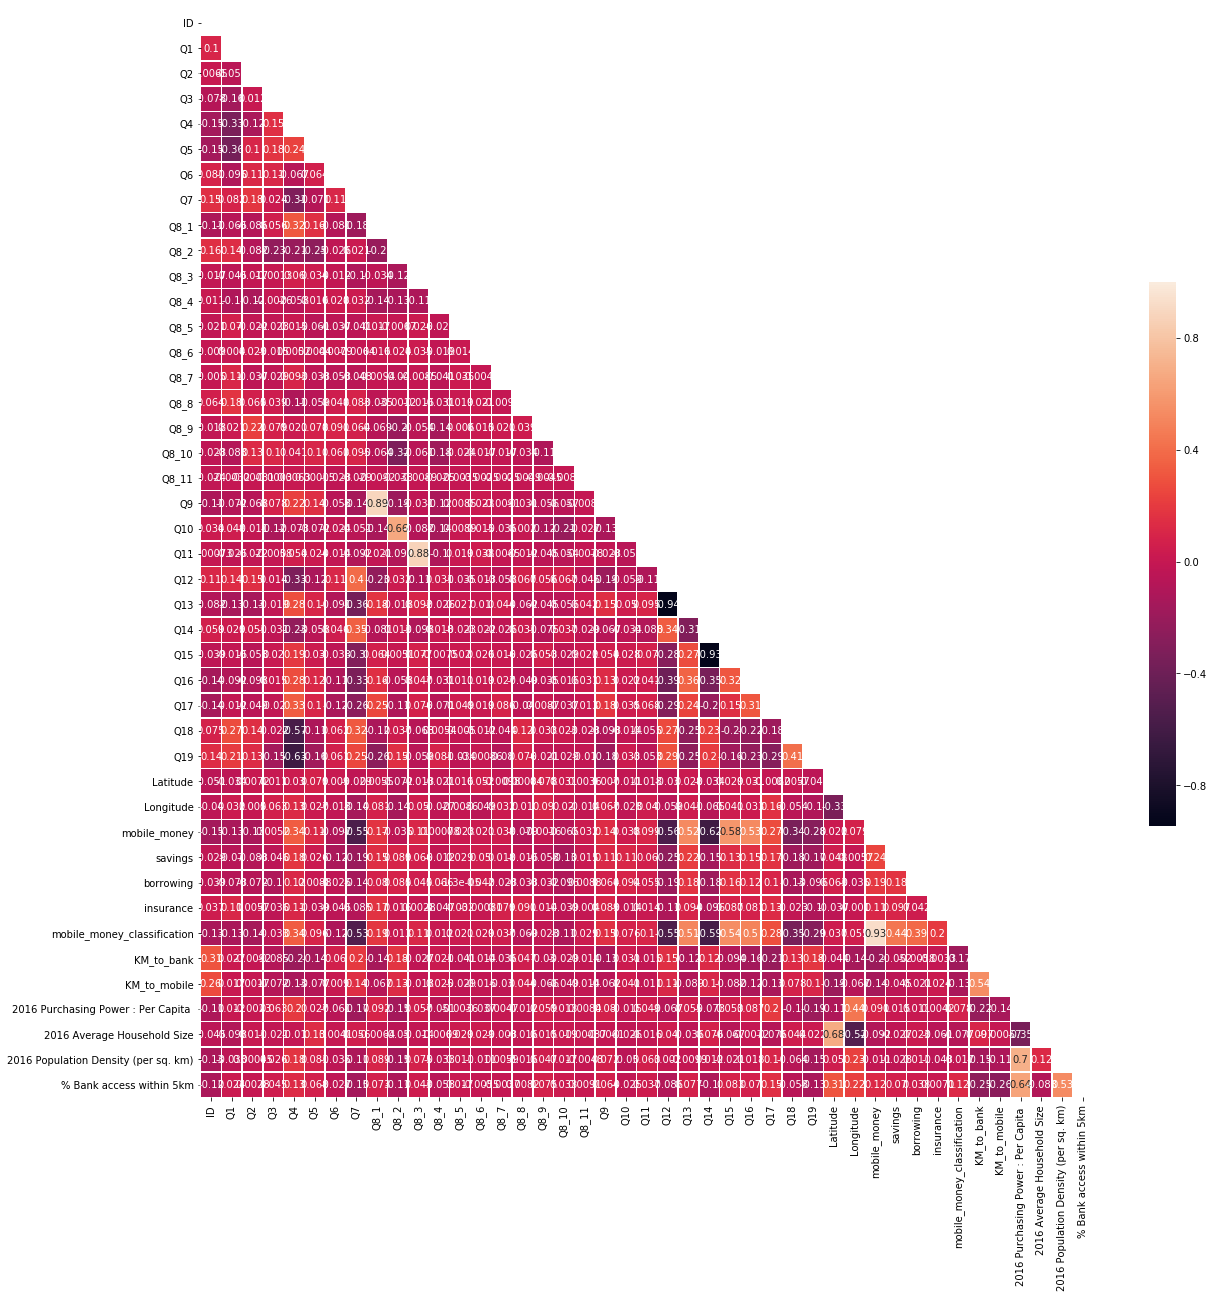

In [32]:
f, ax = plt.subplots(figsize=(20, 20))
corr = train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train.corr(), annot=True, mask=mask,linewidths=.5, ax=ax,cbar_kws={"shrink": .5})

### Data Structure Analysis

In [33]:
# the prediction set has the 32 columns for classification and we will have to predict the target
to_predict.head()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,Q19,Latitude,Longitude,KM_to_bank,KM_to_mobile,Region_Nam,2016 Purchasing Power : Per Capita,2016 Average Household Size,2016 Population Density (per sq. km),% Bank access within 5km
0,2352,30,2,1,3,6,2,1,0,0,...,4,-2.596421,32.913584,1.583605,0.457470,Mwanza,1016570.0,5.8,277.0,58.0
1,8208,53,1,1,3,1,2,1,0,1,...,4,-1.778303,34.062640,41.846446,7.504929,Mara,914733.0,5.6,87.0,38.0
2,2785,23,2,1,3,5,1,1,0,0,...,1,-1.851789,31.536866,12.382164,0.535899,Kagera,910669.0,4.7,109.0,43.0
3,2967,30,2,3,3,4,1,2,0,1,...,4,-1.235656,34.229012,20.238699,8.564699,Mara,914733.0,5.6,87.0,38.0
4,1697,28,2,1,5,4,2,1,0,0,...,2,-7.780934,35.691878,0.859776,0.303721,Iringa,1167978.0,4.3,29.0,22.0


In [34]:
# At first sight we have no missing data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7094 entries, 0 to 7093
Data columns (total 44 columns):
ID                                      7094 non-null int64
Q1                                      7094 non-null int64
Q2                                      7094 non-null int64
Q3                                      7094 non-null int64
Q4                                      7094 non-null int64
Q5                                      7094 non-null int64
Q6                                      7094 non-null int64
Q7                                      7094 non-null int64
Q8_1                                    7094 non-null int64
Q8_2                                    7094 non-null int64
Q8_3                                    7094 non-null int64
Q8_4                                    7094 non-null int64
Q8_5                                    7094 non-null int64
Q8_6                                    7094 non-null int64
Q8_7                                    7094 non-null

In [35]:
to_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365 entries, 0 to 2364
Data columns (total 39 columns):
ID                                      2365 non-null int64
Q1                                      2365 non-null int64
Q2                                      2365 non-null int64
Q3                                      2365 non-null int64
Q4                                      2365 non-null int64
Q5                                      2365 non-null int64
Q6                                      2365 non-null int64
Q7                                      2365 non-null int64
Q8_1                                    2365 non-null int64
Q8_2                                    2365 non-null int64
Q8_3                                    2365 non-null int64
Q8_4                                    2365 non-null int64
Q8_5                                    2365 non-null int64
Q8_6                                    2365 non-null int64
Q8_7                                    2365 non-null

In [36]:
train.head()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,borrowing,insurance,mobile_money_classification,KM_to_bank,KM_to_mobile,Region_Nam,2016 Purchasing Power : Per Capita,2016 Average Household Size,2016 Population Density (per sq. km),% Bank access within 5km
0,5086,98,2,3,1,1,2,2,0,0,...,0,0,0,34.085336,1.110439,Kigoma,817645.0,5.7,51.0,30.0
1,1258,40,1,1,3,5,1,1,1,0,...,1,0,3,2.213349,0.533324,Mjini Magharibi,1861535.0,5.3,3673.0,96.0
2,331,18,2,4,6,3,2,1,0,0,...,0,0,2,1.129646,0.359524,Morogoro,1066101.0,4.4,36.0,37.0
3,6729,50,1,1,3,1,1,1,0,0,...,1,0,3,14.759292,0.513033,Arusha,1323743.0,4.5,48.0,65.0
4,8671,34,1,1,1,1,2,1,0,1,...,0,1,3,35.708657,3.702071,Rukwa,860009.0,5.1,41.0,16.0


In [37]:
# statistics of the training set features
train.describe()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,savings,borrowing,insurance,mobile_money_classification,KM_to_bank,KM_to_mobile,2016 Purchasing Power : Per Capita,2016 Average Household Size,2016 Population Density (per sq. km),% Bank access within 5km
count,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,...,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7094.000000,7.094000e+03,7094.000000,7094.000000,7094.000000
mean,4742.627291,38.239498,1.559910,1.787426,3.060051,2.548915,1.840569,1.397942,0.062165,0.630110,...,0.461517,0.432901,0.151255,1.799267,26.268085,8.502715,1.025001e+06,4.940441,175.773824,39.603335
std,2731.120086,16.332148,0.496433,1.165160,1.557779,1.534257,0.366103,0.489508,0.241472,0.482809,...,0.498552,0.495512,0.358322,1.196955,23.482026,12.861319,1.922993e+05,0.748860,559.149422,17.658969
min,1.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001197,0.000053,7.572990e+05,3.700000,13.000000,4.000000
25%,2397.250000,25.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,5.762511,1.102027,9.019330e+05,4.300000,36.000000,30.000000
50%,4744.500000,35.000000,2.000000,1.000000,3.000000,3.000000,2.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,2.000000,21.087690,3.901732,1.016570e+06,4.940441,51.000000,38.000000
75%,7105.000000,48.000000,2.000000,3.000000,3.000000,4.000000,2.000000,2.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,3.000000,39.675435,11.175385,1.130470e+06,5.600000,95.000000,49.000000
max,9459.000000,100.000000,2.000000,4.000000,8.000000,6.000000,2.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,3.000000,100.000000,139.147608,1.861535e+06,7.000000,3673.000000,96.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002431BA845C0>,
      dtype=object)

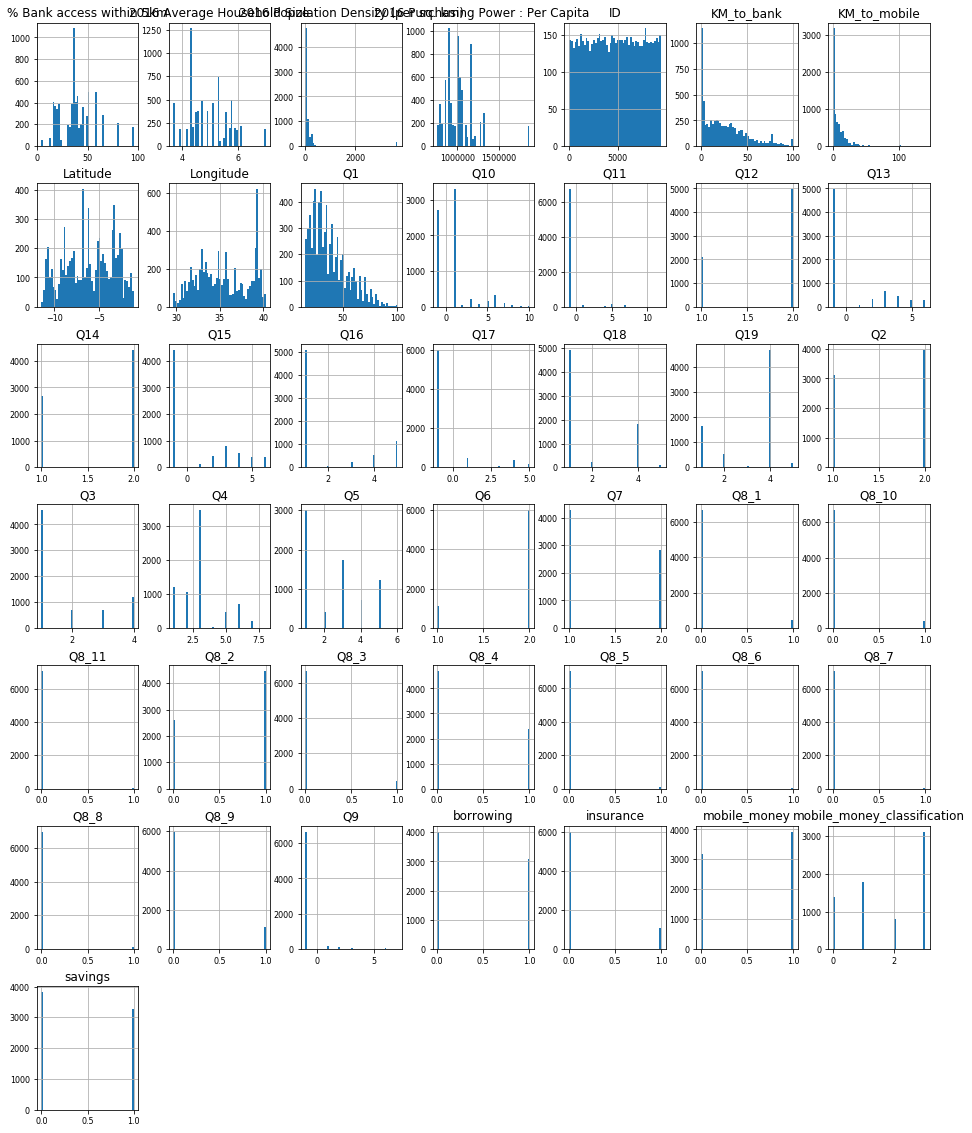

In [38]:
# visualization of the distribution and of the training set features
train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### Detailled analysis of the training set features
It has been done feature by feature, we only let some in this notebook to exemplify. 

AxesSubplot(0.125,0.125;0.775x0.755)
Min : 0.0011975
Max : 100.0
Mode : 100.0
Mean : 26.268085498118158


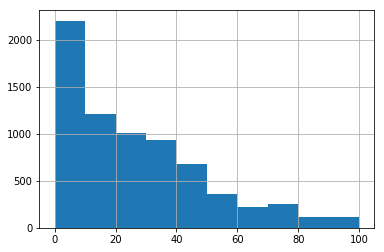

In [39]:
visualize_hist(train,'KM_to_bank')

Text(0,0.5,'Count of Observations')

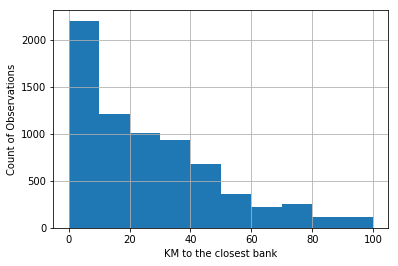

In [40]:
train['KM_to_bank'].hist()
plt.xlabel('KM to the closest bank')
plt.ylabel('Count of Observations')

Text(0,0.5,'Count of Observations')

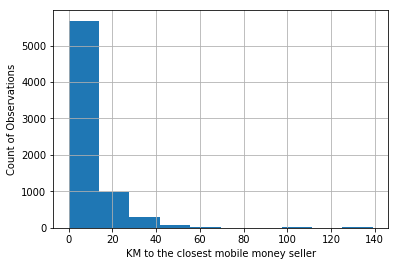

In [41]:
train['KM_to_mobile'].hist()
plt.xlabel('KM to the closest mobile money seller')
plt.ylabel('Count of Observations')

AxesSubplot(0.125,0.125;0.775x0.755)
Min : 5.311e-05
Max : 139.14760816
Mode : 0.10695415
Mean : 8.5027153834945


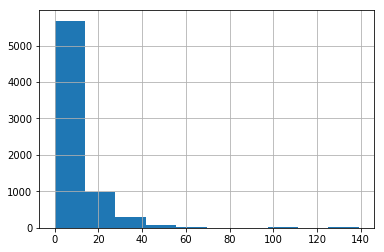

In [42]:
visualize_hist(train,'KM_to_mobile')

AxesSubplot(0.125,0.125;0.775x0.755)
Min : 0
Max : 3
Mode : 3
Mean : 1.7992669861855088


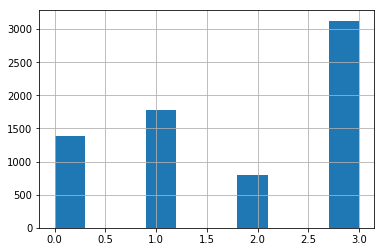

In [43]:
visualize_hist(train,'mobile_money_classification')

#### Relationship between features and targets
It has been done feature by feature, we only let some in this notebook to exemplify. 

#### Target by target
- Exploration of the relationship between variables and target
- Identification of variables that separate the most with the target
- Variables with the biggest positive and negative correlations

AxesSubplot(0.125,0.125;0.775x0.755)


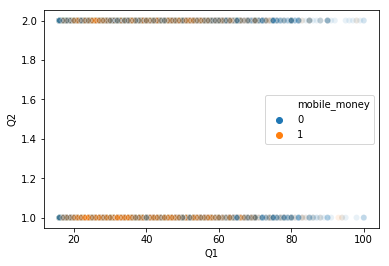

AxesSubplot(0.125,0.125;0.775x0.755)


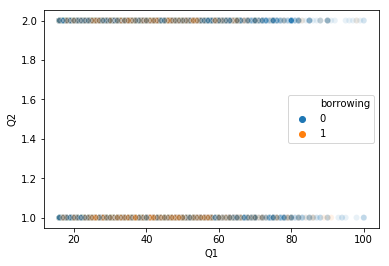

AxesSubplot(0.125,0.125;0.775x0.755)


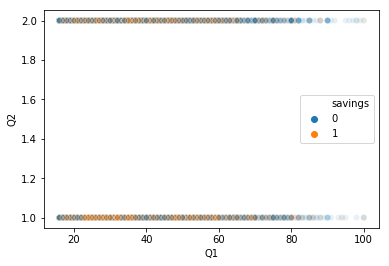

AxesSubplot(0.125,0.125;0.775x0.755)


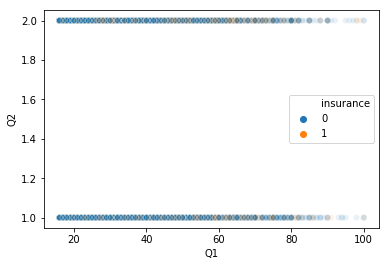

In [44]:
plot_relationship(train,'Q1','Q2')

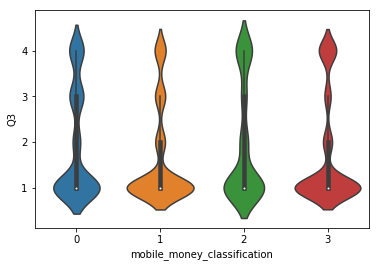

In [45]:
sns.violinplot(x='mobile_money_classification',y='Q3',data=train)

#### Analysis of the main correlations between targets and features

### Mobile Money

In [46]:
train.corr()['mobile_money'].sort_values().tail(10)

Q8_1                           0.172287
borrowing                      0.192710
savings                        0.244746
Q17                            0.274002
Q4                             0.335169
Q13                            0.522983
Q16                            0.526656
Q15                            0.575627
mobile_money_classification    0.927591
mobile_money                   1.000000
Name: mobile_money, dtype: float64

In [47]:
train.corr()['mobile_money'].sort_values().head(10)

Q14            -0.623055
Q12            -0.555411
Q7             -0.550930
Q18            -0.342803
Q19            -0.279599
KM_to_bank     -0.199788
ID             -0.147662
KM_to_mobile   -0.140119
Q2             -0.131080
Q1             -0.130623
Name: mobile_money, dtype: float64

### Savings

In [48]:
train.corr()['savings'].sort_values().head(10)

Q12     -0.248968
Q7      -0.194026
Q18     -0.181674
Q19     -0.173167
Q14     -0.154309
Q8_10   -0.133560
Q6      -0.121290
Q2      -0.083250
Q1      -0.070161
Q8_9    -0.057715
Name: savings, dtype: float64

In [49]:
train.corr()['savings'].sort_values().tail(10)

Q15                            0.128656
Q8_1                           0.149281
Q16                            0.149506
Q17                            0.168943
borrowing                      0.177876
Q4                             0.180151
Q13                            0.215475
mobile_money                   0.244746
mobile_money_classification    0.442081
savings                        1.000000
Name: savings, dtype: float64

### Borrowing

In [50]:
train.corr()['borrowing'].sort_values().head(10)

Q12     -0.189457
Q14     -0.178500
Q7      -0.143032
Q18     -0.134655
Q3      -0.103094
Q19     -0.096460
Q8_10   -0.095692
Q1      -0.073142
Q2      -0.071918
ID      -0.038626
Name: borrowing, dtype: float64

In [51]:
train.corr()['borrowing'].sort_values().tail(10)

Q10                            0.093958
Q17                            0.100910
Q4                             0.116817
Q16                            0.124174
Q15                            0.163121
Q13                            0.176357
savings                        0.177876
mobile_money                   0.192710
mobile_money_classification    0.385427
borrowing                      1.000000
Name: borrowing, dtype: float64

### Insurance

In [52]:
train.corr()['insurance'].sort_values().head(10)

Q12                                    -0.109012
Q19                                    -0.104002
Q14                                    -0.095849
Q7                                     -0.085194
2016 Average Household Size            -0.060899
Q8_4                                   -0.046559
Q6                                     -0.046139
2016 Population Density (per sq. km)   -0.042847
Q5                                     -0.039233
Q8_10                                  -0.038801
Name: insurance, dtype: float64

In [53]:
train.corr()['insurance'].sort_values().tail(10)

Q8_8                           0.091133
Q13                            0.094094
savings                        0.096908
Q1                             0.107807
mobile_money                   0.108093
Q4                             0.109255
Q17                            0.128991
Q8_1                           0.169942
mobile_money_classification    0.198670
insurance                      1.000000
Name: insurance, dtype: float64

## Data Preprocessing

### Create columns and modify based on the observations of the exploratory phase

In [54]:
def preprocessing(dataset):
    
    ## Feature Engineering
    
    #Q1_1 Age by quantiles : Quantiles ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
    quantile_labels = [1, 2, 3, 4]
    quantile_list = [0, .25, .5, .75, 1.]
    dataset['Q1_1'] = pd.qcut(dataset['Q1'], q=quantile_list, labels=quantile_labels)
    #KM_to_banks by quantiles : Quantiles ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
    quantile_labels = [1, 2, 3, 4]
    quantile_list = [0, .25, .5, .75, 1.]
    dataset['KM_to_banks_1'] = pd.qcut(dataset['KM_to_bank'], q=quantile_list, labels=quantile_labels)
    dataset['KM_to_mobile_1'] = pd.qcut(dataset['KM_to_mobile'], q=quantile_list, labels=quantile_labels)
    dataset['2016 Purchasing Power : Per Capita '] = pd.qcut(dataset['2016 Purchasing Power : Per Capita '], q=quantile_list, labels=quantile_labels)
    dataset['2016 Average Household Size'] = pd.qcut(dataset['2016 Average Household Size'], q=quantile_list, labels=quantile_labels)
    dataset['2016 Population Density (per sq. km)'] = pd.qcut(dataset['2016 Population Density (per sq. km)'], q=quantile_list, labels=quantile_labels)
    dataset['% Bank access within 5km'] = pd.qcut(dataset['% Bank access within 5km'], q=quantile_list, labels=quantile_labels)
    # Q3_1 = 1 for married 0 else
    dataset['Q3_1'] = dataset.apply(lambda x: 1 if x['Q3']==1 else 0,axis=1)
    # Q4_1 = 0 if below or equal some primary, 1 if below or equal some secondary 2 for the rest
    dataset['Q4_1'] = dataset.apply(lambda x: 0 if x['Q4']<=2 else 1 if x['Q4']<=5 else 2,axis=1)
    dataset['Q4_1'] = dataset['Q4_1'].astype('category', ordered=True)
    # Q5_1 = Land ownership (1 has a land 0 no)
    dataset['Q5_1'] = dataset.apply(lambda x: 1 if (x['Q5']==1 or x['Q5']==2 or x['Q6']==1) else 0,axis=1)
    # Q8 = Sources of income (count (removed sources like pension, social, rely on someone))
    dataset['Q8'] = dataset.apply(lambda x: x['Q8_1']+x['Q8_2']+x['Q8_3']+x['Q8_4']+x['Q8_5']+x['Q8_6'],axis=1)
    dataset['Q8'] = dataset['Q8'].astype('category', ordered=True)
    # Q12_1 = Send or receive money (2 = No No, 3:Y/N, 4 : Y-Y)
    dataset['Q12_1'] = dataset.apply(lambda x: x['Q12']+x['Q14'],axis=1)
    dataset['Q12_1'] = dataset['Q12_1'].astype('category', ordered=True)
    # Q13_1 Received money (0 : No, 1 : not in the last 3 months, 2 in the last 3 months : )
    dataset['Q13_1'] = dataset.apply(lambda x : 0 if x['Q13']==-1 else 2 if (x['Q13']==1 or x['Q13']==2 or x['Q13']==3) else 1,axis=1)
    dataset['Q13_1'] = dataset['Q13_1'].astype('category', ordered=True)
    # Q15_1 Received money (0 : No, 1 : not in the last 3 months, 2 in the last 3 months : )
    dataset['Q15_1'] = dataset.apply(lambda x : 0 if x['Q15']==-1 else 2 if (x['Q15']==1 or x['Q15']==2 or x['Q15']==3) else 1,axis=1)
    dataset['Q15_1'] = dataset['Q15_1'].astype('category', ordered=True)
    # Q16_1 Used Mobile_money (0 never, 1 less than monthly, 2 monthly or more)
    dataset['Q16_1'] = dataset.apply(lambda x : 0 if (x['Q16']<=1 and x['Q17']<=1) else 1 if (x['Q16']>=5 or x['Q17']>=5) else 2,axis=1)
    dataset['Q16_1'] = dataset['Q16_1'].astype('category', ordered=True)
    # Q18_1 Literacy Kiswhahili (0 no, 1 middle, 2 read and write)
    dataset['Q18_1'] = dataset.apply(lambda x : 0 if x['Q18']>=4 else 1 if x['Q18']>=2 else 2,axis=1)
    dataset['Q18_1'] = dataset['Q18_1'].astype('category', ordered=True)
    # Q19_1 Literacy English (0 no, 1 middle, 2 read and write)
    dataset['Q19_1'] = dataset.apply(lambda x : 0 if x['Q19']>=4 else 1 if x['Q19']>=2 else 2,axis=1)
    dataset['Q19_1'] = dataset['Q19_1'].astype('category', ordered=True)
    # Q20 Literacy English or Kiswhahili (sum)
    dataset['Q20'] = dataset.apply(lambda x : x['Q18_1']+x['Q19_1'],axis=1)
    dataset['Q20'] = dataset['Q20'].astype('category', ordered=True)
    
    ## Remove columns not used 
    #dataset = dataset.drop(columns=['ID', 'Latitude','Longitude'])
    
    ## Columns as category
    for col in ['Q1', 'Q2','Q3','Q4','Q5','Q6','Q7','Q8_1','Q8_2','Q8_3',
             'Q8_4','Q8_5','Q8_6','Q8_7','Q8_8','Q8_9','Q8_10','Q8_11',
             'Q9','Q10','Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19']:
        dataset[col] = dataset[col].astype('category')
    
    return dataset

In [55]:
# Apply the preprocessing function to the training set
preprocessing(train)

C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: specifying 

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,Q4_1,Q5_1,Q8,Q12_1,Q13_1,Q15_1,Q16_1,Q18_1,Q19_1,Q20
0,5086,98,2,3,1,1,2,2,0,0,...,0,1,0,4,0,0,0,0,0,0
1,1258,40,1,1,3,5,1,1,1,0,...,1,1,1,2,1,1,2,2,0,2
2,331,18,2,4,6,3,2,1,0,0,...,2,0,0,4,0,0,0,2,2,4
3,6729,50,1,1,3,1,1,1,0,0,...,1,1,1,3,2,0,2,2,0,2
4,8671,34,1,1,1,1,2,1,0,1,...,0,1,1,3,0,2,0,2,0,2
5,5462,35,1,1,3,3,2,1,0,1,...,1,0,2,3,0,2,0,2,2,4
6,4886,31,2,1,3,1,2,1,0,1,...,1,1,1,2,1,2,0,2,1,3
7,621,23,2,4,5,5,2,1,0,0,...,1,0,1,2,1,1,1,1,1,2
8,8302,56,2,3,3,3,2,2,0,1,...,1,0,3,2,1,1,1,2,2,4
9,4704,37,2,1,3,3,2,1,0,1,...,1,0,1,2,2,1,1,2,0,2


In [56]:
train.columns

Index(['ID', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8_1', 'Q8_2', 'Q8_3',
       'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q9',
       'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19',
       'Latitude', 'Longitude', 'mobile_money', 'savings', 'borrowing',
       'insurance', 'mobile_money_classification', 'KM_to_bank',
       'KM_to_mobile', 'Region_Nam', '2016 Purchasing Power : Per Capita ',
       '2016 Average Household Size', '2016 Population Density (per sq. km)',
       '% Bank access within 5km', 'Q1_1', 'KM_to_banks_1', 'KM_to_mobile_1',
       'Q3_1', 'Q4_1', 'Q5_1', 'Q8', 'Q12_1', 'Q13_1', 'Q15_1', 'Q16_1',
       'Q18_1', 'Q19_1', 'Q20'],
      dtype='object')

In [57]:
train.head()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,Q4_1,Q5_1,Q8,Q12_1,Q13_1,Q15_1,Q16_1,Q18_1,Q19_1,Q20
0,5086,98,2,3,1,1,2,2,0,0,...,0,1,0,4,0,0,0,0,0,0
1,1258,40,1,1,3,5,1,1,1,0,...,1,1,1,2,1,1,2,2,0,2
2,331,18,2,4,6,3,2,1,0,0,...,2,0,0,4,0,0,0,2,2,4
3,6729,50,1,1,3,1,1,1,0,0,...,1,1,1,3,2,0,2,2,0,2
4,8671,34,1,1,1,1,2,1,0,1,...,0,1,1,3,0,2,0,2,0,2


### Additional pre-processing to clean the dataset for the modelling phase

In [58]:
# Additional preprocessing step
### Reduce columns
train = train.drop(columns=['ID', 'Latitude','Longitude'])
### Reduce columns
train = train.drop(columns=['Q1','KM_to_bank','KM_to_mobile','Region_Nam'])
train = train.astype('float')

In [59]:
# Transformation of columns to category for get_dummies
train[['Q3','Q4','Q5','Q9','Q10','Q11']] = train[['Q3','Q4','Q5','Q9','Q10','Q11']].astype('category')

In [60]:
# Initiate Get Dummies
train = pd.get_dummies(train)

In [61]:
# correction of the column names 
train.columns = train.columns.str.replace(".0", "")
# re-change the data type
train = train.astype('int')

In [62]:
# training set after pre-processing
train.head()

,Q2,Q6,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,...,Q11_1,Q11_2,Q11_3,Q11_4,Q11_5,Q11_6,Q11_7,Q11_8,Q11_9,Q11_12
0,2,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# Split Y and X
train_features = train[train.columns.difference(['mobile_money','savings','borrowing','insurance', 'mobile_money_classification'])]
train_label = train.loc[:,'mobile_money_classification']
train_labels = train.loc[:,['mobile_money','savings','borrowing','insurance', 'mobile_money_classification']]
train_labels.head()

,mobile_money,savings,borrowing,insurance,mobile_money_classification
0,0,0,0,0,0
1,1,1,1,0,3
2,1,0,0,0,2
3,1,0,1,0,3
4,1,1,0,1,3


In [64]:
# initiate the testing size, the random seed and the scoring method
test_size = 0.30
seed = 7
score = 'accuracy'
scoring = {'accuracy': 'accuracy',
           'recall': 'precision_macro',
           'f1': 'f1'}

In [65]:
# Split testing set - training set
X_train_all, X_test_all, Y_train_all, Y_test_all = model_selection.train_test_split(train_features, train_label, test_size=test_size, random_state=seed)

### Additional preprocessing steps not used in the final models
Desactived in this Notebook, just presented to exemplify.

## Baseline Definition

Baseline 1 : All equal to the same probability : 0.25

In [66]:
# Shape of the prediction file
to_predict.shape

(2365, 39)

In [67]:
# creation of the baseline 1 for the training file and testing the logloss for this training file
baseline_1 = np.full((4965, 4), 0.25)
print('LogLoss Training : {}'.format(log_loss(Y_train_all, baseline_1)))

LogLoss Training : 1.3862943611198906


In [68]:
# creation of the baseline 1 for the prediction file
baseline_1_predict = np.full((2365, 4), 0.25)

In [69]:
# register as a dataframe
predictions_baseline1 = pd.DataFrame(baseline_1_predict)
# Rename the columns
predictions_baseline1.columns = ['no_financial_services','other_only','mm_only','mm_plus']
# Add the correct index (ID)
predictions_baseline1['ID'] = to_predict2['ID'].astype('int')
predictions = predictions_baseline1.set_index('ID')
predictions.head()

,no_financial_services,other_only,mm_only,mm_plus
ID,,,,
2352,0.25,0.25,0.25,0.25
8208,0.25,0.25,0.25,0.25
2785,0.25,0.25,0.25,0.25
2967,0.25,0.25,0.25,0.25
1697,0.25,0.25,0.25,0.25


Baseline 2 : All individuals have the probalbility of the mean probability of the training set

In [70]:
train_labels_1 = train_labels.drop(['mobile_money_classification'],axis=1)

In [71]:
# creation of on line of the baseline 2 by computing the mean probability of the training set
np.array(pd.DataFrame(train_labels_1).mean())
baseline2 = pd.DataFrame(np.array(pd.DataFrame(train_labels_1).mean())).transpose()
baseline2

,0,1,2,3
0,0.553989,0.461517,0.432901,0.151255


In [72]:
# creation of the baseline 2 for the training file and testing the logloss for this training file
for i in range (0,4964):
    baseline2 = baseline2.append(pd.DataFrame(np.array(pd.DataFrame(train_labels_1).mean())).transpose())
print('LogLoss Training : {}'.format(log_loss(Y_train_all, baseline2)))

LogLoss Training : 1.7007636736408052


In [73]:
baseline2.head()

,0,1,2,3
0,0.553989,0.461517,0.432901,0.151255
0,0.553989,0.461517,0.432901,0.151255
0,0.553989,0.461517,0.432901,0.151255
0,0.553989,0.461517,0.432901,0.151255
0,0.553989,0.461517,0.432901,0.151255


In [74]:
baseline_2_predict = baseline2.reset_index()
baseline_2_predict = baseline_2_predict.drop(['index'],axis=1)
# register as a dataframe
predictions_baseline2 = pd.DataFrame(baseline_2_predict)
# Rename the columns
predictions_baseline2.columns = ['no_financial_services','other_only','mm_only','mm_plus']
# Add the correct index (ID)
predictions_baseline2['ID'] = to_predict2['ID']
predictions2 = predictions_baseline2.set_index('ID')
predictions2.head()

,no_financial_services,other_only,mm_only,mm_plus
ID,,,,
2352.0,0.553989,0.461517,0.432901,0.151255
8208.0,0.553989,0.461517,0.432901,0.151255
2785.0,0.553989,0.461517,0.432901,0.151255
2967.0,0.553989,0.461517,0.432901,0.151255
1697.0,0.553989,0.461517,0.432901,0.151255


In [75]:
predictions2.shape

(4965, 4)

In [76]:
from sklearn.svm import SVC

## Implementation & Refinement
The training cells of the models are descativated after having being trained and the corresponding predictions submitted to the Zindi plateform. The next cells will run with the RF with default parameters.

In [77]:
model = LogisticRegression()
model = model.fit(train_features, train_label)

C:\Users\Flal2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Flal2\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Unoptimized Model Evaluation 

#### Score of the RF on the Zindi Plateform : 1.456

### GridSearch
We performed GridSearch on multiple algorithms, hereafter the one on SVC model

#### Score of the SVC with GridSearch on the Zindi Plateform : 1.372

### TPOT
We performed GridSearch with multiple parameters, hereafter the one that we have been able to run without running time-out of the notebook.

Best pipeline: LogisticRegression(MultinomialNB(SelectFwe(ZeroCount(VarianceThreshold(DecisionTreeClassifier(MinMaxScaler(input_matrix), criterion=gini, max_depth=5, min_samples_leaf=14, min_samples_split=15), threshold=0.001)), alpha=0.039), alpha=0.001, fit_prior=True), C=0.1, dual=False, penalty=l2)

#### Score of the TPOT best pipeline on the Zindi Plateform : 1.368

### Deep Learning
See other Jupyter Notebook for Deep Learning (because trained separately on the Kaggle platform)

### Other Techniques

In [78]:
# Calibration
calibrated_model = CalibratedClassifierCV(model, cv=2, method='sigmoid')

In [79]:
### Predict / Validation of scores
model_label_train = model.predict(X_train_all.astype('float'))
model_label_test = model.predict(X_test_all.astype('float'))
model_label_train_prob = model.predict_proba(X_train_all.astype('float'))
model_label_test_prob = model.predict_proba(X_test_all.astype('float'))
#print(pd.DataFrame(model_label_train).head())
#print(pd.DataFrame(model_label_train_prob).head())
print('LogLoss Training : {}'.format(log_loss(Y_train_all, model_label_train_prob)))
print('Accuracy Training : {}'.format(accuracy_score(Y_train_all, model_label_train)))
print('LogLoss Testing : {}'.format(log_loss(Y_test_all, model_label_test_prob)))
print('Accuracy Testing : {}'.format(accuracy_score(Y_test_all, model_label_test)))
#model.score(train_features.astype('float'), train_label.astype('float'))
#model.score(test_features.astype('float'), test_label.astype('float'))

LogLoss Training : 0.7648726848164781
Accuracy Training : 0.6696878147029205
LogLoss Testing : 0.7730333254802155
Accuracy Testing : 0.6829497416627525


In [80]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 405  543    2   45]
 [ 250  909    5   78]
 [  29   56   15  460]
 [  36  129    7 1996]]
Normalized confusion matrix
[[0.40703518 0.54572864 0.00201005 0.04522613]
 [0.20128824 0.73188406 0.00402576 0.06280193]
 [0.05178571 0.1        0.02678571 0.82142857]
 [0.01660517 0.05950185 0.00322878 0.92066421]]


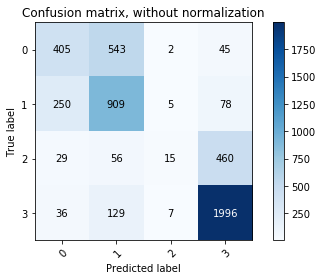

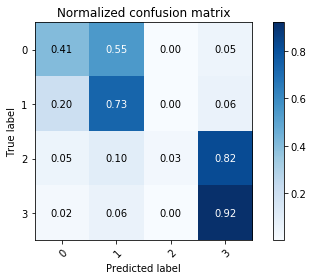

In [81]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_train_all, model_label_train, classes=[0, 1, 2,3],title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_train_all, model_label_train, classes=[0, 1, 2,3], normalize=True,title='Normalized confusion matrix')

plt.show()

### Predictions and Pipeline to save to the csv format required by Zindi

In [82]:
to_predict.head()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,Q19,Latitude,Longitude,KM_to_bank,KM_to_mobile,Region_Nam,2016 Purchasing Power : Per Capita,2016 Average Household Size,2016 Population Density (per sq. km),% Bank access within 5km
0,2352,30,2,1,3,6,2,1,0,0,...,4,-2.596421,32.913584,1.583605,0.457470,Mwanza,1016570.0,5.8,277.0,58.0
1,8208,53,1,1,3,1,2,1,0,1,...,4,-1.778303,34.062640,41.846446,7.504929,Mara,914733.0,5.6,87.0,38.0
2,2785,23,2,1,3,5,1,1,0,0,...,1,-1.851789,31.536866,12.382164,0.535899,Kagera,910669.0,4.7,109.0,43.0
3,2967,30,2,3,3,4,1,2,0,1,...,4,-1.235656,34.229012,20.238699,8.564699,Mara,914733.0,5.6,87.0,38.0
4,1697,28,2,1,5,4,2,1,0,0,...,2,-7.780934,35.691878,0.859776,0.303721,Iringa,1167978.0,4.3,29.0,22.0


In [83]:
to_predict.columns

Index(['ID', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8_1', 'Q8_2', 'Q8_3',
       'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q8_9', 'Q8_10', 'Q8_11', 'Q9',
       'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19',
       'Latitude', 'Longitude', 'KM_to_bank', 'KM_to_mobile', 'Region_Nam',
       '2016 Purchasing Power : Per Capita ', '2016 Average Household Size',
       '2016 Population Density (per sq. km)', '% Bank access within 5km'],
      dtype='object')

#### Apply to the Test Set the same pre-processing transformation made to the Training Set

In [84]:
# Transform the data_predict dataframe
preprocessing(to_predict)

C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\Flal2\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: specifying 

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,...,Q4_1,Q5_1,Q8,Q12_1,Q13_1,Q15_1,Q16_1,Q18_1,Q19_1,Q20
0,2352,30,2,1,3,6,2,1,0,0,...,1,0,1,2,1,1,1,2,0,2
1,8208,53,1,1,3,1,2,1,0,1,...,1,1,1,3,0,1,0,2,0,2
2,2785,23,2,1,3,5,1,1,0,0,...,1,1,1,2,1,1,0,2,2,4
3,2967,30,2,3,3,4,1,2,0,1,...,1,1,1,4,0,0,0,2,0,2
4,1697,28,2,1,5,4,2,1,0,0,...,1,0,1,2,1,1,2,2,1,3
5,4794,52,2,1,3,3,2,1,0,1,...,1,0,1,3,0,1,0,2,1,3
6,2675,17,2,4,3,3,2,1,1,0,...,1,0,1,4,0,0,2,2,2,4
7,2989,30,2,1,3,3,1,1,0,1,...,1,1,1,2,1,2,1,2,0,2
8,1634,42,2,1,6,2,2,1,0,0,...,2,1,2,4,0,0,0,2,2,4
9,4147,45,2,1,3,1,2,1,0,1,...,1,1,2,3,0,2,0,2,0,2


In [86]:
# Additional preprocessing step
### Reduce columns
to_predict = to_predict.drop(columns=['ID', 'Latitude','Longitude'])
### Reduce columns
to_predict = to_predict.drop(columns=['Q1','KM_to_bank','KM_to_mobile','Region_Nam'])
to_predict = to_predict.astype('float')

In [87]:
# Transformation of columns to category for get_dummies
to_predict[['Q3','Q4','Q5','Q9','Q10','Q11']] = to_predict[['Q3','Q4','Q5','Q9','Q10','Q11']].astype('category')

In [88]:
# Initiate Get Dummies
to_predict1 = pd.get_dummies(to_predict)

In [89]:
to_predict1.head()

,Q2,Q6,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,...,Q10_10.0,Q11_-1.0,Q11_1.0,Q11_3.0,Q11_4.0,Q11_5.0,Q11_7.0,Q11_8.0,Q11_9.0,Q11_12.0
0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


In [90]:
# correction of the column names 
to_predict1.columns = to_predict1.columns.str.replace(".0", "")
# re-change the data type
to_predict1 = to_predict1.astype('int')

In [91]:
to_predict1.columns

Index(['Q2', 'Q6', 'Q7', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q8_9', 'Q8_', 'Q8_11', 'Q12', 'Q13', 'Q14', 'Q15',
       'Q16', 'Q17', 'Q18', 'Q19', '16 Purchasing Power : Per Capita ',
       '16 Average Household Size', '16 Population Density (per sq. km)',
       '% Bank access within 5km', 'Q1_1', 'KM_to_banks_1', 'KM_to_mobile_1',
       'Q3_1', 'Q4_1', 'Q5_1', 'Q8', 'Q12_1', 'Q13_1', 'Q15_1', 'Q16_1',
       'Q18_1', 'Q19_1', 'Q', 'Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q4_1', 'Q4_2',
       'Q4_3', 'Q4_4', 'Q4_5', 'Q4_6', 'Q4_7', 'Q4_8', 'Q5_1', 'Q5_2', 'Q5_3',
       'Q5_4', 'Q5_5', 'Q5_6', 'Q9_-1', 'Q9_1', 'Q9_2', 'Q9_3', 'Q9_4', 'Q9_5',
       'Q9_6', 'Q9_7', 'Q_-1', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7',
       'Q_8', 'Q_9', 'Q_', 'Q11_-1', 'Q11_1', 'Q11_3', 'Q11_4', 'Q11_5',
       'Q11_7', 'Q11_8', 'Q11_9', 'Q11_12'],
      dtype='object')

In [92]:
to_predict1.head()

,Q2,Q6,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,...,Q_,Q11_-1,Q11_1,Q11_3,Q11_4,Q11_5,Q11_7,Q11_8,Q11_9,Q11_12
0,2,2,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,2,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,1,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2,1,2,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2,2,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
### Align the columns between the Test and Training Set, differences could appeard with the Get_dummies (if not the algorithm will not be able to train)

In [93]:
missing_columns = (set(train_features.columns) - set(to_predict1.columns))
for i in missing_columns:
        to_predict1[i] = 0

In [94]:
missing_columns

{'Q11_2', 'Q11_6'}

In [95]:
additional_columns = (set(to_predict1.columns) - set(train_features.columns))
for i in additional_columns:
    to_predict1 = to_predict1.drop(columns=i)

In [96]:
to_predict1.head()

,Q2,Q6,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,...,Q11_1,Q11_3,Q11_4,Q11_5,Q11_7,Q11_8,Q11_9,Q11_12,Q11_2,Q11_6
0,2,2,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,2,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
to_predict = to_predict1.astype('int')

#### Predictions

In [99]:
# Prectid the probabilities with the model trained and Save the predictions in a DataFrame
predictions = pd.DataFrame(model.predict_proba(to_predict))

In [100]:
predictions.head()

,0,1,2,3
0,1.881335e-07,0.000023,0.228870,0.771106
1,2.521292e-06,0.000005,0.003088,0.996904
2,1.179282e-03,0.000784,0.081121,0.916916
3,1.319119e-05,0.000065,0.053572,0.946350
4,3.457687e-04,0.010965,0.023994,0.964695


#### Formatting for csv file

In [101]:
# Rename the columns
predictions.columns = ['no_financial_services','other_only','mm_only','mm_plus']
# Add the correct index (ID)
predictions['ID'] = to_predict2['ID']
predictions = predictions.set_index('ID')
predictions.head()

,no_financial_services,other_only,mm_only,mm_plus
ID,,,,
2352,1.881335e-07,0.000023,0.228870,0.771106
8208,2.521292e-06,0.000005,0.003088,0.996904
2785,1.179282e-03,0.000784,0.081121,0.916916
2967,1.319119e-05,0.000065,0.053572,0.946350
1697,3.457687e-04,0.010965,0.023994,0.964695


In [102]:
predictions.shape

(2365, 4)

#### Download of Csv file
Blocked

#### Submission of the csv to the Zindi website
https://zindi.africa/competitions/mobile-money-and-financial-inclusion-in-tanzania-challenge/submissions